## Import & Setup

Note, you can ignore this error:

```
ISAAC SIM may not to be installed. Please install it to use full GO4R functionality.
```

This message appears because this notebook imports packages from the GO4R extension, but it _does not_ need Isaac Sim.

In [180]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo
%pip install -U kaleido

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

Isaac Sim not found; Isaac Sim-specific features will not work.
USD not found; USD-specific features will not work.
Open3D not found; Open3D-specific features will not work.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
78728.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
78733.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
78739.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


## !! Put the run ID here !!

In [181]:
robot_name = "anymal_c"
run_date_string = "20250506"
run_time_string = "184959"

run_id = f"{robot_name}_{run_date_string}_{run_time_string}"

## Get the Problem & Solution Data

### Problem from the JSON

In [182]:
results_dir = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/"
json_prolem_path = f"{results_dir}problem_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

### Generated designs from CSV

In [183]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)

#### Add some additional stats to the DT for visualization

In [184]:
new_headers = []

# Add up the different sensor types
for k, so in problem.sensor_options.items():
    if so is None:
        continue
    sensor_option_name = so.name
    new_headers.append(f"Total '{sensor_option_name}'s ({k})")
    df[f"Total '{sensor_option_name}'s ({k})"] = (df[[f"s{i}_type" for i in range(problem.max_n_sensors)]] == k).sum(axis=1)

# Add up the total sensors
df[f"Total Sensors"] = df[new_headers].sum(axis=1)
new_headers.append(f"Total Sensors")

df

,id,Name,Generation,Cost,Perception Entropy,Perception Coverage,s0_type,s0_x,s0_y,s0_z,...,s5_y,s5_z,s5_qw,s5_qx,s5_qy,s5_qz,Total 'VLP16_Puck_LITE's (1),Total 'RSD455's (2),Total 'ZED_X's (3),Total Sensors
0,0,Design 0,0,6826.0,2.087938,0.994039,2,0.461650,0.000000,0.370800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,4,0,5
1,1,Design 1,1,6769.0,6.618805,0.621709,2,-0.356577,-0.134916,0.336032,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,2,4
2,2,Design 2,1,7369.0,3.073204,0.914555,3,0.273874,-0.119795,0.480075,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,3,5
3,3,Design 3,1,17069.0,5.454162,0.742921,1,0.409293,-0.031720,0.391596,...,-0.021250,0.454582,-0.874347,0.035900,0.428869,-0.224276,3,1,2,6
4,4,Design 4,1,12338.0,6.609840,0.642077,1,0.438886,-0.150096,0.503683,...,0.005526,0.551569,0.048933,-0.253662,0.385671,-0.885731,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5596,5596,Design 5596,80,1438.0,2.764507,0.999503,3,0.191926,0.096682,0.535314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,1,3
5597,5597,Design 5597,80,1857.0,2.698476,0.999503,3,0.191926,0.096682,0.498950,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3,1,4
5598,5598,Design 5598,80,1619.0,2.756373,1.000000,3,0.201550,0.108228,0.537350,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,2,3
5599,5599,Design 5599,80,11319.0,1.842287,1.000000,1,0.138412,0.060749,0.377939,...,-0.011183,0.331632,0.999680,-0.025300,0.000000,0.000000,2,1,1,4


## NSGA-II Convergence

Plot the hypervolume convergence over time. This can be helpful to plot halfway through to see if the algorithm thinks it is converging.

Note: If you don't provide a reference point, it will use the extents of ALL the generated designs (opposite of the utopia point), so the Hypervolume result may be different if the algorithm finds less optimal designs.

In [185]:
hv_plot, ref_point = plot_hypervolume_over_time(df)
hv_plot

## Objective Trade Space

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

Note: These can take a very long time to generate, especially if you have thousands or tens-of-thousands of designs!!

### Perception Entropy vs Cost

In [186]:
obj_trade_fig = plot_tradespace(df)
obj_trade_fig

In [187]:
# Save the objective trade space figure as a PNG
output_path = os.path.join(results_dir, f"TRADESPACE_{run_id}.png")
obj_trade_fig.write_image(output_path)
print(f"Saved tradespace to {output_path}")

Saved tradespace to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/TRADESPACE_anymal_c_20250506_184959.png


### Perception Coverage vs Cost

In [188]:
obj2_trade_fig = plot_tradespace(
    df, 
    x=("Total Sensors", "sensors"), 
    x_minimize=True,
    y=("Perception Coverage", "fraction"),
    y_minimize=False,
)
obj2_trade_fig

In [189]:
# Save the objective trade space figure as a PNG
output_path = os.path.join(results_dir, f"TRADESPACE_2_{run_id}.png")
obj2_trade_fig.write_image(output_path)
print(f"Saved tradespace to {output_path}")

Saved tradespace to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/TRADESPACE_2_anymal_c_20250506_184959.png


## Pair Plots

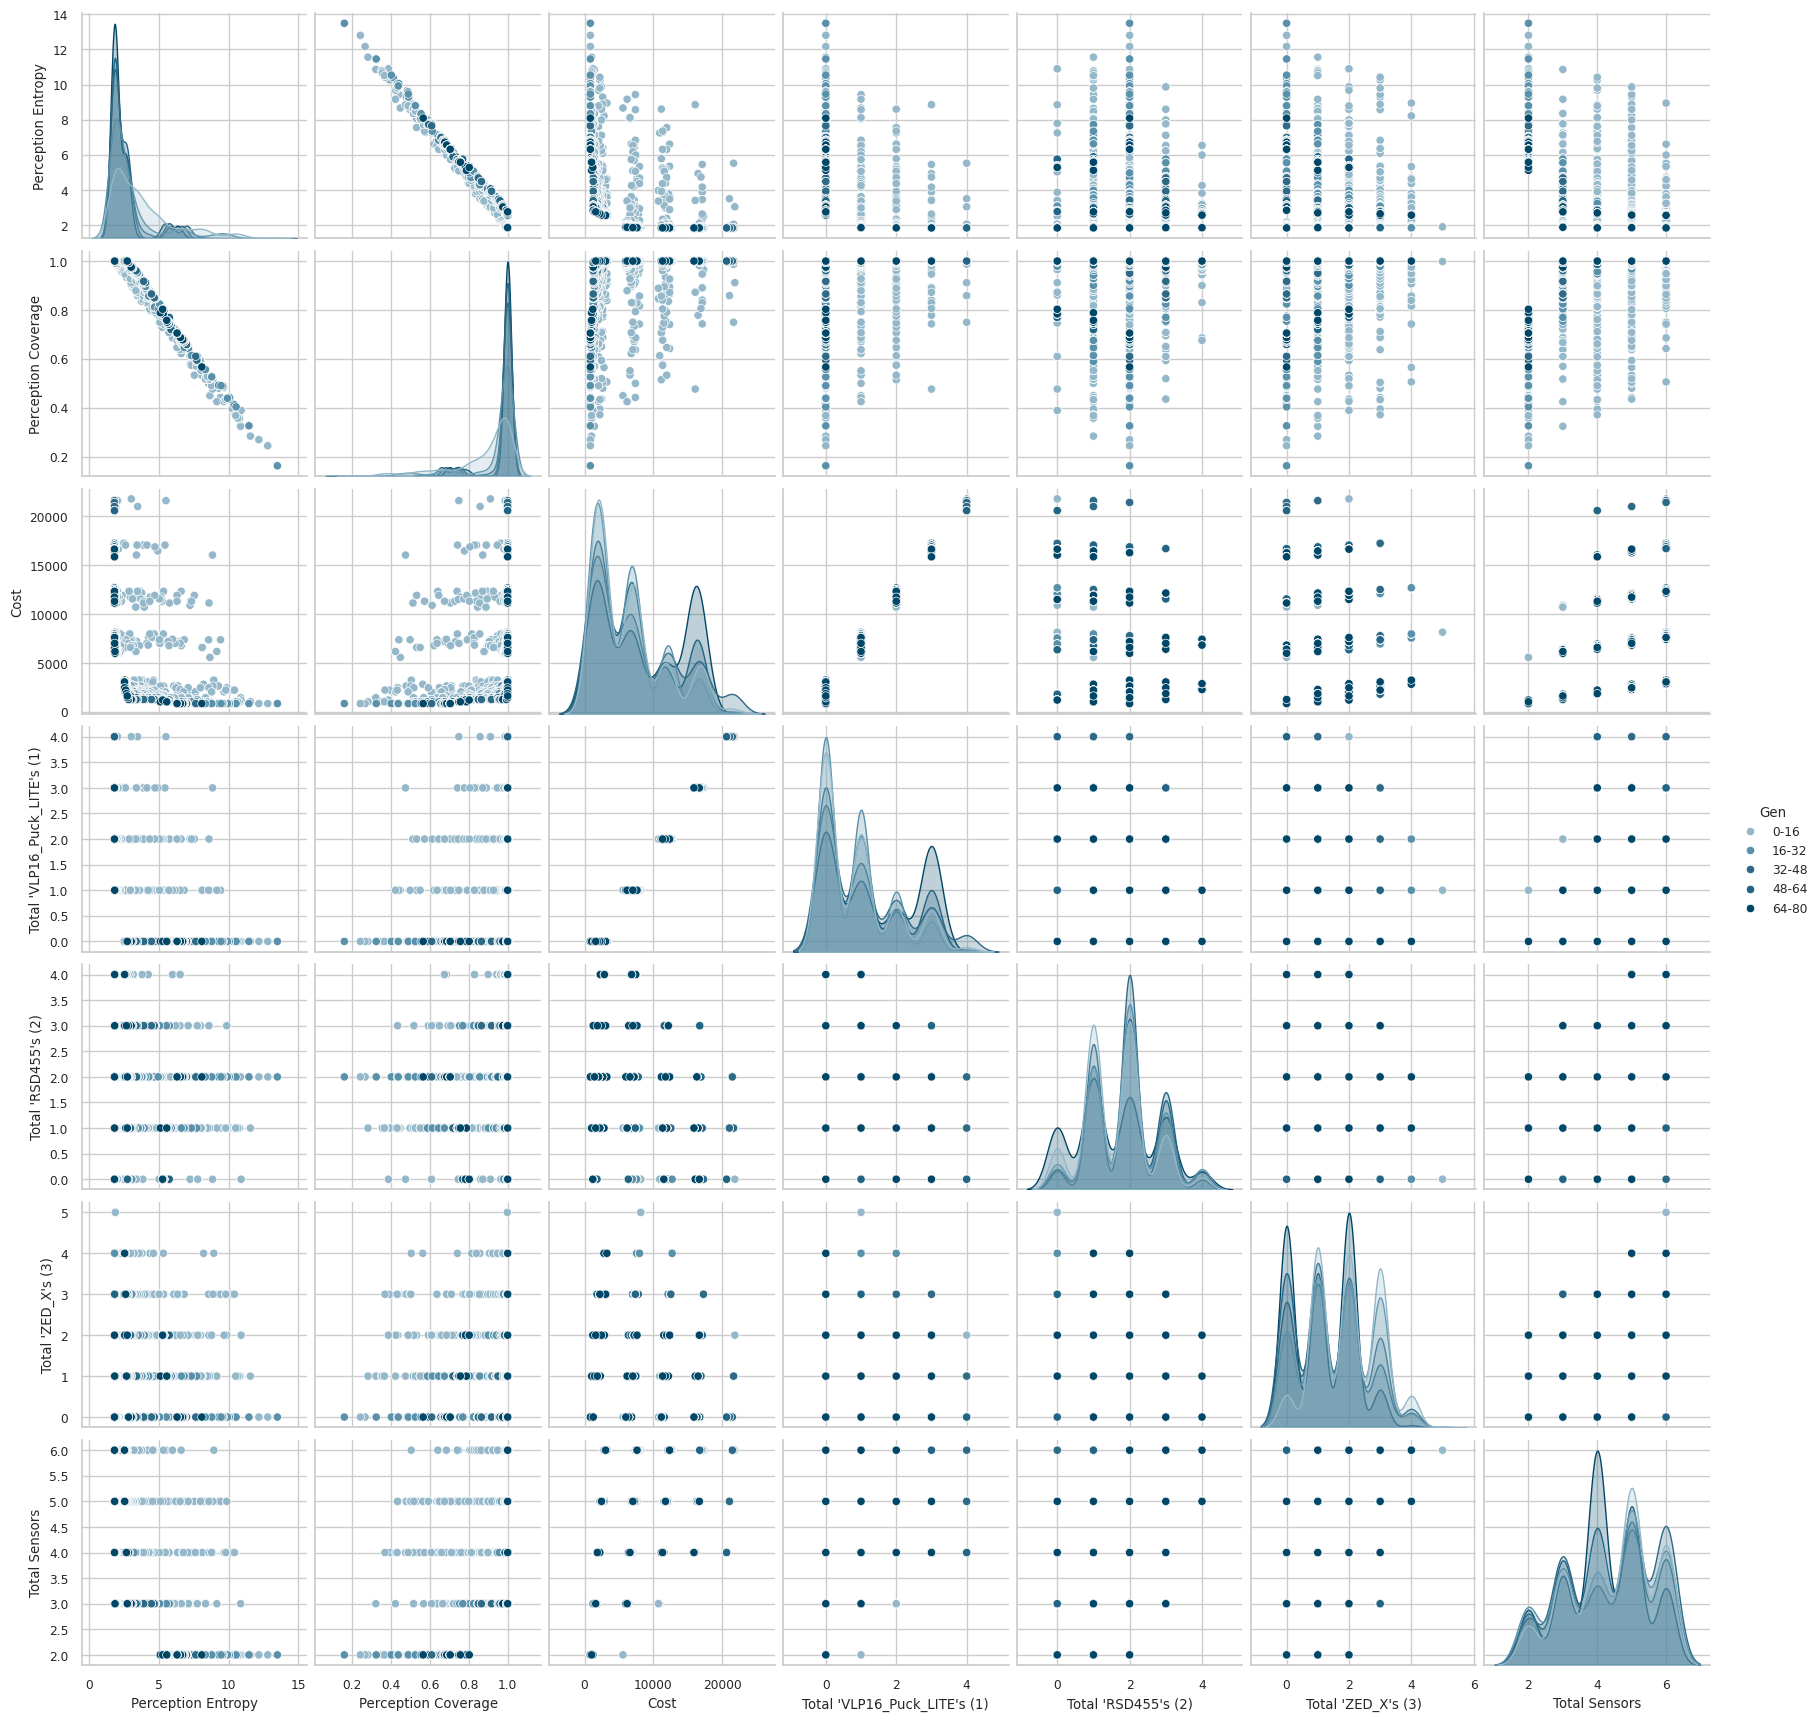

In [190]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=.8)
sns_blues = sns.color_palette(color_scale_blue)
sns.set_palette(sns_blues)

pair_plot_df = df[["Generation", "Perception Entropy", "Perception Coverage", "Cost"] + new_headers].copy()

# Drop "Design 0" because it is the prior design
pair_plot_df = pair_plot_df[pair_plot_df["Generation"] != 0]

n_gens = pair_plot_df["Generation"].nunique()
if n_gens > 5:
    bins = 5
else:
    bins = n_gens

if bins > 2: # There were not enough generations to fill the first 2 bins
    # Bin generations groups and label each bin "X-Y"
    gen_cat = pd.cut(pair_plot_df["Generation"], bins=bins, include_lowest=True)
    bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in gen_cat.cat.categories]
    pair_plot_df["Gen"] = gen_cat.cat.rename_categories(bin_labels)
    pair_plot_df.drop(columns=["Generation"], inplace=True)

    pair_plot_fig = sns.pairplot(
        pair_plot_df,
        hue="Gen",
        diag_kind="kde",
        palette=sns_blues
        )
else:
    pair_plot_fig = sns.pairplot(
        pair_plot_df,
        diag_kind="kde"
        )


In [191]:
# Save the pair plot figure as a PNG
output_path = os.path.join(results_dir, f"PAIR_PLOT_{run_id}.png")
pair_plot_fig.savefig(output_path, dpi=400)
print(f"Saved pair plot to {output_path}")

Saved pair plot to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/PAIR_PLOT_anymal_c_20250506_184959.png


## Plot any bot from the df above

### Helper fns and data

In [192]:
sensor_constraints_mesh_data = box_mesh_data(
    problem.s_bounds,
    opacity=0.25,
    color='blue',
    name='Sensor Pose Constraints',
    legendgroup="Sensor Pose Constraints",
    showlegend=True,
    hoverinfo='skip'
)

def plot_bot_design(design_idx, sensor_idx_rays=None, max_rays=100, ray_length=1.0):
    design_x_df = df[df["id"] == design_idx]
    design_x_dict = design_x_df.iloc[0].to_dict()
    bot_x = problem.convert_1D_to_bot(design_x_dict)
    design_x_fig = bot_x.plot_bot_3d(
        perception_space=problem.perception_space,
        show=False,
        show_sensor_pose_constraints=False,
        max_rays=max_rays,
        ray_length=ray_length,
        show_sensor_rays=sensor_idx_rays,
        width=800,
    )
    design_x_fig.add_trace(sensor_constraints_mesh_data)
    
    design_x_fig.update_layout(
        title=f"Design {design_idx}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data",
        ),
        margin=dict(l=0, r=0, b=0, t=30),
    )

    design_x_fig.show()

    return design_x_fig, design_x_df

### Plot any Bot!

In [193]:
# Here is the first one
design_0_fig, design_0_df = plot_bot_design(0, sensor_idx_rays=4, max_rays=100)

design_0_df

,id,Name,Generation,Cost,Perception Entropy,Perception Coverage,s0_type,s0_x,s0_y,s0_z,...,s5_z,s5_qw,s5_qx,s5_qy,s5_qz,Total 'VLP16_Puck_LITE's (1),Total 'RSD455's (2),Total 'ZED_X's (3),Total Sensors,Pareto Optimal
0,0,Design 0,0,6826.0,2.087938,0.994039,2,0.46165,0.0,0.3708,...,0.0,0.0,0.0,0.0,0.0,1,4,0,5,


In [205]:
INDEX_TO_PLOT = 5247 #2526 #2389
design_x_fig, design_x_df = plot_bot_design(INDEX_TO_PLOT, sensor_idx_rays=3, max_rays=100)
design_x_df

OutOfMemoryError: CUDA out of memory. Tried to allocate 102.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 70.25 MiB is free. Including non-PyTorch memory, this process has 930.00 MiB memory in use. Process 51770 has 5.25 GiB memory in use. Of the allocated memory 716.83 MiB is allocated by PyTorch, and 25.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [195]:
INDEX_TO_PLOT = 3436
design_x_fig, design_x_df = plot_bot_design(INDEX_TO_PLOT, sensor_idx_rays=1, max_rays=100)
design_x_df

,id,Name,Generation,Cost,Perception Entropy,Perception Coverage,s0_type,s0_x,s0_y,s0_z,...,s5_z,s5_qw,s5_qx,s5_qy,s5_qz,Total 'VLP16_Puck_LITE's (1),Total 'RSD455's (2),Total 'ZED_X's (3),Total Sensors,Pareto Optimal
3436,3436,Design 3436,50,6169.0,1.884085,0.996274,2,0.182037,0.097212,0.549765,...,0.331632,0.0,1.0,0.0,0.0,1,1,1,3,


## Random Testing

### Ray/Voxel Traversal (measurement) test case

In [201]:
ro = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]])
rd = torch.tensor([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[np.sqrt(0.5), np.sqrt(0.5), 0.0]])

simple_perception_space = PerceptionSpace(usd_context=None,
                                          voxel_groups=[PerceptionSpace.VoxelGroup(
                                                name="simple",
                                                voxels=['','','','',''],
                                                voxel_centers=torch.tensor([
                                                    #  X     Y     Z
                                                    [-0.5, -0.5,  0.0],  # Behind the sensor, should have 0 hits
                                                    [ 0.0,  0.0,  0.0],    # At center of sensor, should have 3 hits
                                                    [ 0.5,  0.0,  0.0],      # Along x-axis, should have 1 hit
                                                    [ 1.0,  0.5,  0.0],     # Should have 0 hits
                                                    [ 0.0,  1.0,  0.0],    # Should have 0 hits if occluded, 1 if not
                                                    ]),
                                                voxel_sizes=torch.tensor([0.1,0.1,0.1,0.1,0.1]).unsqueeze(1),
                                          )
                                          ],
                                          weights=[1.0]
)

simple_sensor:Sensor3D_Instance = Sensor3D_Instance(
    sensor=Sensor3D(
        name="simple_sensor",
    ),
    path='',
    tf=((0, 0, 0), (1, 0, 0, 0)),
    name="simple_sensor_instance",
)

body_aabb_extents = [
    [(-0.1,  0.1), ( 0.4,  0.6), (-0.1,  0.1)], # This one only occludes the voxel at (0,1,0)
    # [(-0.1,  0.1), (-0.1,  0.1), (-0.1,  0.1)], # This one occludes everythin because sensor is at (0,0,0)
    ]
body_mesh_data = []
for i, aabb in enumerate(body_aabb_extents):
    
    body_mesh_data.append(
        box_mesh_data(
            extents=body_aabb_extents[i], 
            color="red", 
            opacity=0.2, 
            name=f"Occluder {i}"
        )
    )

# display(torch.tensor([[1.0, 0, 0.5],[2.0, 0, 0.5]]).size())
# display(torch.tensor([0.5,0.5]).size())

one_ray_fig = simple_perception_space.plot_me(show=False, mode='boxes')
simple_sensor.plot_rays(ro, rd, show=False, max_rays=5, fig=one_ray_fig, ray_length=1.25)
for i, aabb in enumerate(body_aabb_extents):
    one_ray_fig.add_trace(body_mesh_data[i])


one_ray_fig

Isaac Sim not found; Isaac Sim-specific features will not work.
USD not found; USD-specific features will not work.
Open3D not found; Open3D-specific features will not work.


In [202]:
simple_perception_space.chunk_ray_voxel_intersections(ro, rd, verbose=True)

 Batch ray voxel intersection traversal took 0.01 seconds for 3 rays and 5 voxels.
  VOXEL HITS max: 3, min: 0


tensor([0, 3, 1, 0, 1], device='cuda:0')

In [203]:
simple_perception_space.chunk_occluded_ray_voxel_intersections(ro, rd, verbose=True)

Done in 0.00s for 3 rays × 5 voxels; hits max=3, min=0


tensor([0, 3, 1, 0, 1], device='cuda:0')

In [204]:
simple_perception_space.chunk_occluded_ray_voxel_intersections(ro, rd, body_aabbs=body_aabb_extents, verbose=True)

Done in 0.00s for 3 rays × 5 voxels; hits max=3, min=0


tensor([0, 3, 1, 0, 0], device='cuda:0')